# Pic16b Final Project by Samantha Wong and Varsha Rayasam
- The goal of our project was to use machine learning to predict prognoses for patients (ie. Lyme disease, Zika, etc), using the presence or lack of symptoms (ie. nose bleed, rash, headache, etc). We tried using a KNN model that would predict 1 prognosis and a LightGBM decision tree model that would predict the likelihoods that a patient would have each disease. We took the highest 3 probablities and used a MAP@k metric to assess the accuracy of the modeL

In [ ]:
#if on colab need to pip install prince, then restart session to run

In [ ]:
#pip install prince


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import prince
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# **Pre-Processing Data**
- Our training data is comprised of 707 instances, with 66 columns. 1 of these features is the "ID" number of the instance, which is useless for training our model, so it will later be dropped. 65 of the columns are features that are associated with a symptom (ie. nose bleed, rash, headache, etc). All of these features are in binary meaning that if they were present in the patient then there is a 1 in that column and not present then a 0. The last column is the prognosis of the patient (ie. Lyme disease, Zika, etc). This will be split off from the training data and used for y-vales (what we are trying to predict). The test data does not have this last prognosis (y-value) column, so it was not used to train or access the model, but the predictions made from the models with the test data are shown at the end

In [5]:
train = pd.read_csv('/Users/srivarsharayasam/Downloads/pic16bproj/train.csv')

#test data does not have y values, so train is split into validation
test = pd.read_csv("/Users/srivarsharayasam/Downloads/pic16bproj/test.csv")

In [ ]:
train

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,702,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Plague
703,703,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Malaria
704,704,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
705,705,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Plague


In [6]:
train.shape

(707, 66)

## Correlation Heatmap between features of data
- This plot shows the correlation coefficients between all pairs of symptoms in the training data frame. The higher the correlation coefficient, the more often two symptoms were found together.

/var/folders/8c/ngntdyvn3bz1q97j4nbx_1jc0000gn/T/ipykernel_23465/2295614684.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=df.corr()


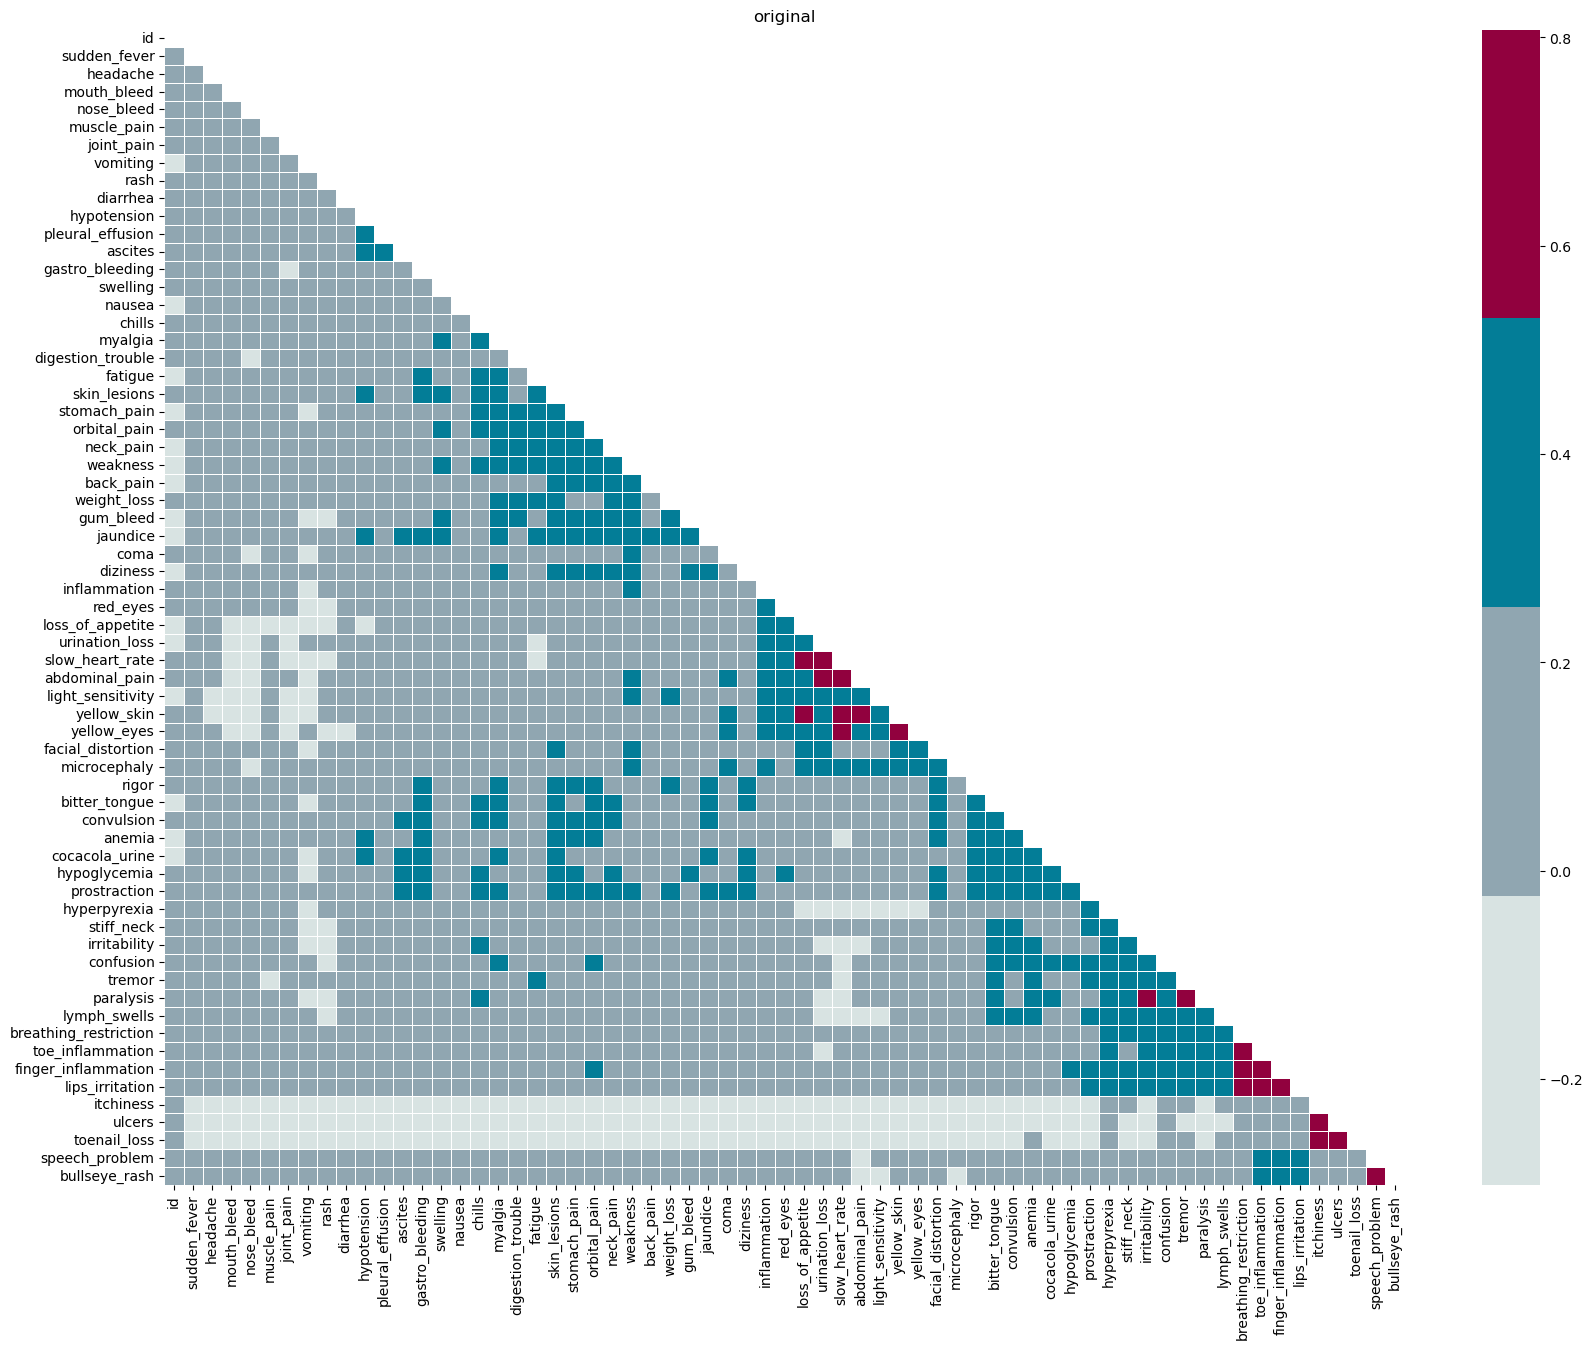

In [7]:
#this function creates a heatmap using df.corr() and visualizes it using a heatmap. It also uses a mask to
#use in the heatmap parameter
def heatmap(df,title):
   #use df.corr to find pearsen correlation between symptoms
   corr=df.corr()
   fix, axes=plt.subplots(figsize=(20,15))
   #create mask of zeroes
   mask=np.zeros_like(corr)
   mask[np.triu_indices_from(mask)]=True
   #palette of colors
   palette = ['#302c36', '#037d97', '#91013E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']
   #creating heatmap
   sns.heatmap(corr, mask=mask,linewidths=0.5, cmap=palette[5:][::-2] + palette[1:3], annot=False)
   plt.title(title)
   plt.show()


heatmap(train,'original')

## Split Training into train and validation and encode

- Because the test data did not come with y-values (predicted values), we split the training data to be used for training and validation. We chose a 80%/20% split, because our data set was not huge at 707 data points, but large enough that we could have use a standard split.


In [8]:
#x = train.loc[:, train.columns != 'prognosis'] #get all columns but "prognosis" predicting for, and id (useless for prediction)
x =  train.drop(["prognosis","id"],axis=1)

#encode categorical prognosis into numerical format
le = LabelEncoder()
y = le.fit_transform(train["prognosis"])

#split training data further to get validation data
#random state ensures that it stays the same after each running
x_train, x_val, y_train, y_val =  train_test_split(x, y, test_size=0.2,random_state=42)
#test df has unlabeled prognosis



In [9]:
#data frame showing what each numerical code represents which prognosis
encoding_dict = {label: encoded_value for label, encoded_value in zip(le.classes_, le.transform(le.classes_))}
encoding_key = pd.DataFrame([encoding_dict])
encoding_key

,Chikungunya,Dengue,Japanese_encephalitis,Lyme_disease,Malaria,Plague,Rift_Valley_fever,Tungiasis,West_Nile_fever,Yellow_Fever,Zika
0,0,1,2,3,4,5,6,7,8,9,10


## MCA
- Multiple Correspondence Analysis or MCA is used to dimensionality reduce our data by analyzing relationships between categorical variables in a data set. It is similar to PCA, but it is designed for categorical data. The MCA Variable Plot shows that if features are close together in the plot, than they are similar in terms of their contribution to the MCA components, while features that are far apart are dissimilar. The colors of the points indicate the different symptoms from the original data, allowing you to visually inspect how symptoms are related in the MCA plot.

The data is transformed using MCA, then fed into the models

In [10]:
#Multiple Correspondence Analysis
#Technique used for dimensionality reduction (extension of PCA)
mca = prince.MCA(
    n_components=20, #using 20 variables, because I tested with multiple component sizes and this had best (origincal data has 66)
    n_iter=5, #number of iterations of algorithm used to fit MCA model
    copy=True, #original data set not modified
    check_input=True, #check for NaNs or inf
    engine='sklearn', #using sklearn for computation
    one_hot = False #categorical variables already encoded
)

mca = mca.fit(x_train) #fit MCA model


In [11]:

# get coordinates of each feature in the MCA plot
variables_coordinates = mca.column_coordinates(x_train)

# Create a Plotly scatter plot with legend
fig = px.scatter(variables_coordinates, x=0, y=1, color=variables_coordinates.index)

# Update layout
fig.update_layout(title='MCA: Variable Plot', xaxis_title='Component 1', yaxis_title='Component 2')

# Show the plot
fig.show()

In [12]:
x_train_mca = mca.fit_transform(x_train) #fit and trainsform train data
x_val_mca = mca.transform(x_val) #trainsform validation data with same model

## **KNN**

For the KNN model, we used the preprocessed MCA output to improve accuracy.
KNN is a supervised learning algorithm, where K is the number of nearest neighbors, as opposed to the number of clusters in k means. We tested three different values for k and got these three predictions.
K=10, accuracy: 0.27
K=5, accuracy: 0.25
K=3, accuracy: 0.24

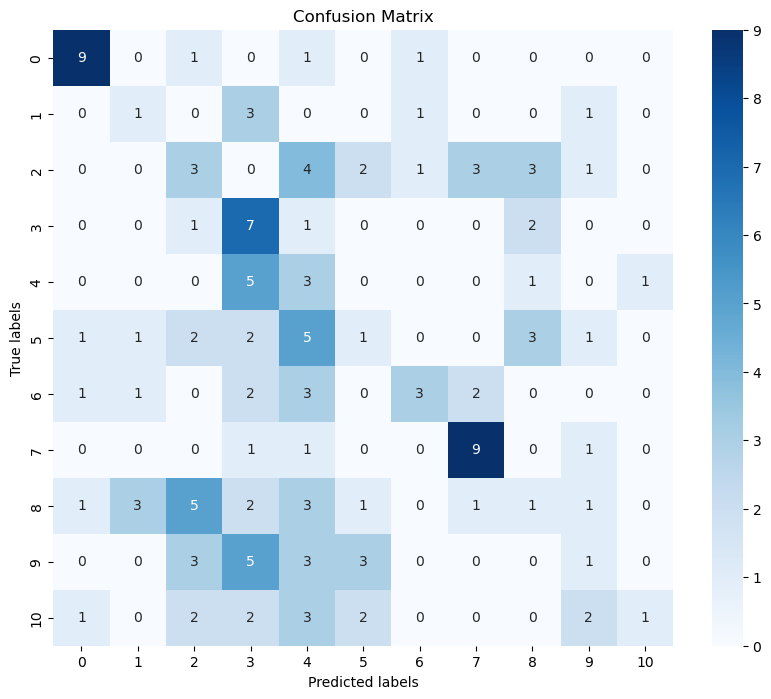

Accuracy: 0.2746478873239437


In [20]:
#train the KNN model
knn = KNeighborsClassifier(n_neighbors=10)
#arbitrarily tested values to find optimal k
knn.fit(x_train_mca, y_train)

#make predictions on the test data
y_pred_knn = knn.predict(x_val_mca)

#confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_knn)
plt.figure(figsize=(10, 8))
#fmt=d for annotation, cmap=Blues for blue hue
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

#calculate accuracy
accuracy = accuracy_score(y_val, y_pred_knn)
print("Accuracy:", accuracy)

In [14]:
#encoding key to cross reference with confusion matrix
encoding_key

,Chikungunya,Dengue,Japanese_encephalitis,Lyme_disease,Malaria,Plague,Rift_Valley_fever,Tungiasis,West_Nile_fever,Yellow_Fever,Zika
0,0,1,2,3,4,5,6,7,8,9,10


## **Light GBM Model**
- LightGBM uses tree-based learning algorithms using gradient boosting. It uses decision trees, which recursively partition the data into subsets based on the features values and each node of the tree represents a prediction value. LightGBM is different than a simple decision tree becayse it uses leaf-wise growth strategy for building tree, which is selecting the leaf that reduces loss the most.

In [21]:
##set model parameters
params={}
params['learning_rate']=0.01
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=7
params['num_class']=11 #no.of unique values in the target class not inclusive of the end value
params['verbose']=-1

#convert data into LGB format
d_train=lgb.Dataset(x_train_mca, label=y_train)
#d_train=lgb.Dataset(x_train, label=y_train)

#training the model
clf=lgb.train(params,d_train,500)  #training the model on 2,000 epocs


#prediction on the validation dataset
#for each ID, predicts probablity of each disease type
y_pred_1=clf.predict(x_val_mca)
#shape = (# of IDs, # of disease classifications - 11)

### MAP@k (Mean Average Precision at k)
- I used a MAP@K score ( to evaluate the Light GBM model since it gives likelihood of the patient having each prognosis, instead of just choosing one. Therefore, I wanted to get the top 3 prognoses.

After taking in the top 3 prognoses, MAP@K calculates the precision at each position in the list of recommendations, considering how accurate that prediction at that rank is. Then it calculates the average precision by taking the mean of the precisions at each position up to k or 3 in this case.
Then it calculates the mean of the average precisions across all instances.




In [22]:
def apk(actual, predicted, k=11):
    """
    Computes the average precision at k. Used to evaluate LightGBM model.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>=k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=11):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

## Accuracy Testing for LightGBM on Validation Data

In [23]:
#gets top 3 prognoses for each ID
top_3 = np.argsort(-y_pred_1, axis=1)[:,:3]
top_3.shape

(142, 3)

In [24]:
top_3_val_names = le.inverse_transform(top_3.flatten()).reshape(-1,3) #flatten top_3 from (142,3) to 1D array to work with le.inverse_transform(), then reshape back to (142,3)
y_val_names = le.inverse_transform(y_val).reshape(-1,1) #reshape so that each true prognosis is its own list

#map@k using written labels
map_score = mapk(y_val_names,top_3_val_names, k=3 ) #calulate map@k score using true prognonis, top 3 predicted prognosis(in order of most to least likely), and 3 is for the number of predictions
print(f'map@k score is {map_score}')

map@k score is 0.38262910798122074


In [25]:
#put results of validation testing into a dataframe
val_results = pd.DataFrame(top_3_val_names,columns = ["Diagnosis 1", "Diagnosis 2","Diagnosis 3"])
val_results["True Prognosis"] = y_val_names

In [26]:
val_results

,Diagnosis 1,Diagnosis 2,Diagnosis 3,True Prognosis
0,Japanese_encephalitis,Dengue,Rift_Valley_fever,Dengue
1,West_Nile_fever,Rift_Valley_fever,Tungiasis,West_Nile_fever
2,Dengue,West_Nile_fever,Rift_Valley_fever,West_Nile_fever
3,Japanese_encephalitis,Plague,Yellow_Fever,Japanese_encephalitis
4,Tungiasis,Dengue,Rift_Valley_fever,Rift_Valley_fever
...,...,...,...,...
137,Chikungunya,Dengue,Japanese_encephalitis,Chikungunya
138,West_Nile_fever,Lyme_disease,Japanese_encephalitis,Plague
139,Plague,West_Nile_fever,Tungiasis,West_Nile_fever
140,Tungiasis,Dengue,Rift_Valley_fever,Tungiasis


## **Test Data**
- This part uses the models trained and evaluated from before, and runs this on the test data with no y-values

In [27]:
#mca transform test data
x_test_mca = mca.transform(test)

## Light GBM

In [28]:
#predict prognosis fo test data
test_preds = clf.predict(x_val_mca)


#get top 3 most likely prognosis
top_3_test = np.argsort(-test_preds, axis=1)[:,:3]
#transform from encoded to written prognosis
top_3_test_names = le.inverse_transform(top_3_test.flatten()).reshape(-1,3)

#turn predictions into data frame
test_results = pd.DataFrame(top_3_test_names, columns = ["Diagnosis 1", "Diagnosis 2","Diagnosis 3"])

test_results.insert(loc=0, column='ID', value=test.id) #insert back IDs

test_results

,ID,Diagnosis 1,Diagnosis 2,Diagnosis 3
0,707,Japanese_encephalitis,Dengue,Rift_Valley_fever
1,708,West_Nile_fever,Rift_Valley_fever,Tungiasis
2,709,Dengue,West_Nile_fever,Rift_Valley_fever
3,710,Japanese_encephalitis,Plague,Yellow_Fever
4,711,Tungiasis,Dengue,Rift_Valley_fever
...,...,...,...,...
137,844,Chikungunya,Dengue,Japanese_encephalitis
138,845,West_Nile_fever,Lyme_disease,Japanese_encephalitis
139,846,Plague,West_Nile_fever,Tungiasis
140,847,Tungiasis,Dengue,Rift_Valley_fever


In [29]:
y_pred_test_knn = knn.predict(x_test_mca) #use knn model to predict test data
test_knn_names = le.inverse_transform(y_pred_test_knn) #inverse transform encoding into written prognosis
knn_test_results = pd.DataFrame(test_knn_names, columns = ["Knn Diagnosis"]) #put results into data frame
knn_test_results.insert(loc=0, column='ID', value=test.id) #insert back IDs

In [30]:
knn_test_results

,ID,Knn Diagnosis
0,707,Dengue
1,708,Dengue
2,709,Lyme_disease
3,710,Dengue
4,711,Lyme_disease
...,...,...
298,1005,Malaria
299,1006,Malaria
300,1007,Lyme_disease
301,1008,Lyme_disease
